#Installing and importing required library

In [ ]:
!pip install simpletransformers

The cell below should be executed twice. So don't worry if you get an error in first execution.

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score	
from simpletransformers.classification import ClassificationModel
from simpletransformers.config.model_args  import ClassificationArgs 
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import classification_report
from scipy.special import softmax
from tqdm import tqdm
import seaborn as sns

#Loading and Preparing Data


#####Useful gloabl variabls


In [ ]:
DATA_PATH = "/content/drive/MyDrive/data_defi_ia"
TRAIN_AND_VALIDATE = True  #set this variable to true if you want to train on Train_size%
                            #and validate your model on the rest of data if False the model will
                            #be trained on the entire dataset
Train_size = 0.8
Text_column = 'description'  #name of text column in my dataFrame
Label_column = 'label'      #name of labels column in my dataFrame
Confidence_porb = 0.999  #we will use this in Data augmentation section

#####loading data

In [ ]:
drive.mount('/content/drive')
df = pd.read_json(DATA_PATH+"/train.json").set_index('Id')
df_test = pd.read_json(DATA_PATH+"/test.json").set_index('Id')
train_label = pd.read_csv(DATA_PATH+"/train_label.csv").set_index('Id')
df[Label_column]=train_label['Category']

Mounted at /content/drive


####Analysing our text vocabulary
We can notice that there are a lot of stopwords but we will keep them. Because our transformer are trained on data that contain stopwords so they actually improve our score.
When we ignore them we can see (in the visualization) that the most commonn words are related to some specific jobs.

In [ ]:
# function to create vocab
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.description[i].split())
    return(vocab)

# call vocabulary creation function on train dataset
vocab = create_vocab(df)

# lets check the no. of words in the vocabulary
len(vocab)
# lets check the most common 10 words in the vocabulary
vocab.most_common(10)

[('and', 680595),
 ('the', 528399),
 ('of', 467574),
 ('in', 428973),
 ('a', 252204),
 ('to', 178708),
 ('is', 169835),
 ('for', 145339),
 ('He', 137384),
 ('has', 136251)]

In [ ]:
def word_cloud(df):
    comment_words = '' 
    stopwords = set(STOPWORDS) 
    # iterate through the csv file 
    for val in df.description: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 
        
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
        #return comment_words

    wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

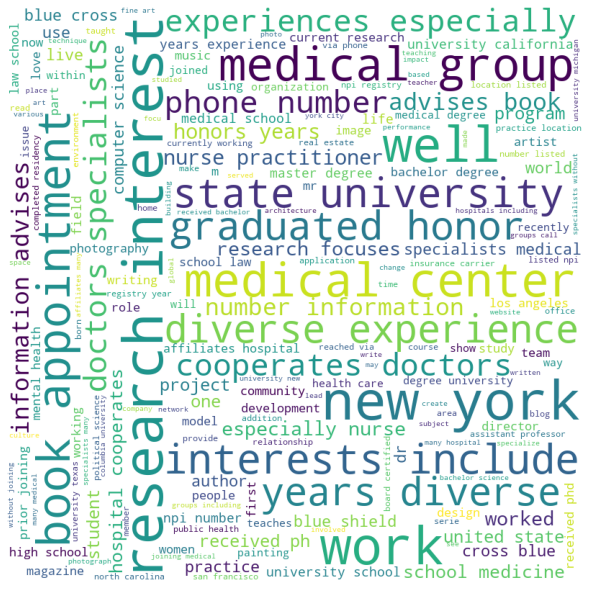

In [ ]:
#visualising our vocabulary
word_cloud(df)

### Class imbalance

We can see clearly the imbalance in our data train , we have a lack of data for some classes

In [ ]:
plt.figure(figsize = (10, 8))
sns.countplot(df[Label_column ])
plt.title("Frequence of features of each class")
plt.show()

In [ ]:
print("Class repartition : ", (Counter(df[Label_column])))

###Number of features for each gender and job

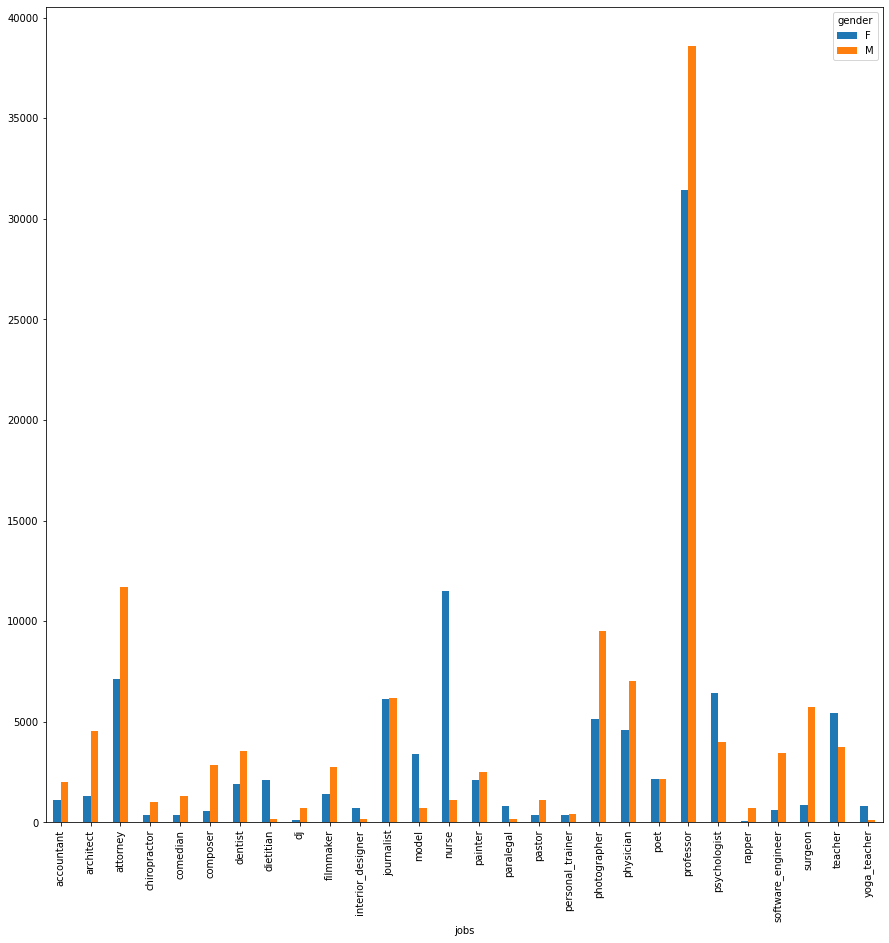

In [ ]:
names = pd.read_csv(DATA_PATH+'/categories_string.csv')['0'].to_dict()
jobs=df['label']
jobs=jobs.map(names)
df['label_names']=jobs
genders_jobs=df[['gender','label_names']]
genders_jobs.columns=['gender','jobs']
df2plot=genders_jobs.groupby(['gender','jobs']).size().unstack('gender')
df2plot.plot(kind='bar',figsize=(15,15))

#Data cleaning
We will use transformers as models , and after trying several methods for cleaning data to improve our model we end up finding that those transformers don't need much cleaning.
The important thing to do here is to eliminate words that indicate genders ,this trick did improve our fairness score but worsen our f1 score a bit.


In [ ]:
w2remove=['he','she','his','her','him','hers','male','female']

def remove_w(text):
  w2remove=['he','she','his','her','him','hers','male','female']
  text=" ".join([w for w in text.split() if w not in w2remove])
  return text

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """

    text = text.lower()# lowercase text
    text=re.sub(r"http\S+", "", text)
    text=re.sub(r"www\S+", "", text)
    text = re.sub('\S*@\S*\s?',' ', text) #remove emails
    text=remove_w(text)

    return str(text)
  
df[Text_column] = df[Text_column].apply(text_prepare)
df_test[Text_column] = df_test[Text_column].apply(text_prepare)

#Building model
We will use simpletransformers library to build our pre-trained roberta model.

If GPU is unavailable use_cuda parameter should be set to False.
If you are in colab and you get an error for the first execution just
restart the runtime and run all cells again.

In [ ]:
model_args = ClassificationArgs()
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.train_batch_size= 32
model_args.num_train_epochs = 2
model_args.learning_rate = 2e-5
model_args.no_cache = True
model_args.save_model_every_epoch = False
model_args.save_eval_checkpoints = False
model_args.save_steps= 20000 

Num_labels = num_classes = np.max(df[Label_column].values) + 1
model = ClassificationModel('roberta','roberta-large', num_labels=Num_labels,use_cuda=True, args=model_args)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

#Train and evaluate our model

In [ ]:
def f1_multiclass(labels, preds):	
      return f1_score(labels, preds, average='macro')

In [ ]:
df = df[[Text_column,Label_column]]

if TRAIN_AND_VALIDATE :
  train_df = df[:int(Train_size*len(df))]
  eval_df = df[int(Train_size*len(df)):]
  model.train_model(train_df,f1=f1_multiclass, acc=accuracy_score)
else :
  model.train_model(df,f1=f1_multiclass, acc=accuracy_score)  

In [ ]:
if TRAIN_AND_VALIDATE :
  predictions = model.predict(eval_df[Text_column].values)
  labels_flat = eval_df[Label_column].values.flatten()  

  target_names = [str(i) for i in eval_df[Label_column].unique()]
  print(classification_report(labels_flat, predictions[0], target_names=target_names))


#Get predictions on test dataset

In [ ]:
predictions = model.predict(df_test[Text_column].values)

  0%|          | 0/54300 [00:00<?, ?it/s]

  0%|          | 0/6788 [00:00<?, ?it/s]

#Data Augmentation
We will use the Pseudo labeling method :
Pseudo labeling is the process of adding confidently predicted test data to our training data.
After trying several methods to improve our score the Pseudo labeling was the best one

In [ ]:
raw_outputs = predictions[1]
probabilities = softmax(raw_outputs, axis=1)
indices={}
count=0
for i in tqdm(range(len(probabilities))):
  if np.max(probabilities[i,:])>=Confidence_porb:
    indices[i]=np.argmax(probabilities[i,:])
    count += 1
print(count)

100%|██████████| 54300/54300 [00:00<00:00, 190181.81it/s]

0


In [ ]:
df_selected=df_test[Text_column][list(indices.keys())]
new_train=pd.DataFrame(df_selected)
new_train[Label_column]=list(indices.values())
new_train = new_train[[Text_column,Label_column]]
df = df.append(new_train)

####Lets's train again our model and get our new predictions

In [ ]:
model = ClassificationModel('roberta','roberta-large', num_labels=Num_labels,use_cuda=True, args=model_args)
model.train_model(df,f1=f1_multiclass, acc=accuracy_score)  
predictions = model.predict(df_test[Text_column].values)

#Fairness metric

In [ ]:
def macro_disparate_impact(people):
    counts = people.groupby(['job', 'gender']).size().unstack('gender')
    counts['disparate_impact'] = counts[['M', 'F']].max(axis='columns') / counts[['M', 'F']].min(axis='columns')
    return counts['disparate_impact'].mean()

In [ ]:
df_test = pd.read_json(DATA_PATH+"/test.json")
y_pred = pd.Series(predictions[0], name='job', index=df_test.Id)
gender_test = df_test[['Id','gender']].set_index('Id')
test_people = pd.concat((y_pred, gender_test), axis='columns')
macro_disparate_impact(test_people)

1.3195007088750703

#Generate the submission file

In [ ]:
df_test["Category"] = predictions[0]
submission_file = df_test[["Id","Category"]]
submission_file.to_csv("/content/sample_data/submission.csv", index=False)